### Import necessary libraries

https://github.com/dpicone1/Heath_Jarrow_Morton_Model/blob/master/HJM.ipynb

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import date
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.integrate import quad
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import CubicSpline


### Paramters

In [2]:
start = date(2014, 1, 1)
BUSINESS_N_YEAR = 252
EXPLAIN_LEVEL = 0.90
simulation_tenors = np.linspace(0,50,51)
series_code = ['THREEFF1', 'THREEFF2','THREEFF3','THREEFF4','THREEFF5','THREEFF6', 'THREEFF7', 'THREEFF8', 'THREEFF9', 'THREEFF10']
series_name = ['1Y3m', '2Y3m','3Y3m','4Y3m','5Y3m','6Y3m', '7Y3m', '8Y3m', '9Y3m', '10Y3m']

### Read data

In [3]:
#fwdrates = DataReader(series_code, 'fred', start)
#fwdrates.to_csv('threef.csv')
fwdrates = pd.read_csv('hjm_data.csv').set_index('time') 
fwdrates.interpolate(method='linear', limit_direction='both', axis=0,inplace=True)
fwdrates = fwdrates/100
tenors =  [i for i in range(len(fwdrates.columns))]
spot_rates = fwdrates.tail(1).values[0]
timeline = np.linspace(0,5,500)
simulation_tenors=tenors
fwdrates

,1/12,1/2,1,1.5,2,2.5,3,3.5,4,4.5,...,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25
time,,,,,,,,,,,,,,,,,,,,,
1,0.057734,0.064382,0.067142,0.066512,0.064991,0.063255,0.061534,0.059925,0.058444,0.057058,...,0.034194,0.034772,0.035371,0.035985,0.036612,0.037252,0.037902,0.038562,0.039231,0.039908
2,0.057680,0.064506,0.067502,0.066842,0.065423,0.063852,0.062301,0.060846,0.059490,0.058198,...,0.033790,0.034437,0.035108,0.035798,0.036504,0.037224,0.037959,0.038705,0.039461,0.040227
3,0.057758,0.064410,0.067354,0.066845,0.065577,0.064109,0.062611,0.061164,0.059782,0.058438,...,0.032706,0.033294,0.033907,0.034539,0.035188,0.035853,0.036533,0.037224,0.037927,0.038639
4,0.057430,0.064103,0.066942,0.066215,0.064904,0.063462,0.062006,0.060601,0.059252,0.057933,...,0.031325,0.031891,0.032486,0.033106,0.033748,0.034409,0.035088,0.035784,0.036493,0.037214
5,0.057412,0.063978,0.066358,0.065502,0.064168,0.062722,0.061262,0.059849,0.058488,0.057157,...,0.030119,0.030667,0.031250,0.031862,0.032499,0.033161,0.033844,0.034546,0.035264,0.035997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,0.046421,0.045093,0.042471,0.042081,0.042663,0.043224,0.043640,0.043940,0.044156,0.044314,...,0.040260,0.040098,0.039950,0.039813,0.039687,0.039571,0.039464,0.039365,0.039273,0.039187
1261,0.046233,0.044976,0.042452,0.042131,0.042726,0.043285,0.043699,0.043998,0.044214,0.044374,...,0.040307,0.040147,0.039999,0.039863,0.039737,0.039621,0.039514,0.039414,0.039320,0.039233
1262,0.046348,0.045311,0.043295,0.043266,0.043963,0.044565,0.045003,0.045323,0.045560,0.045739,...,0.041276,0.041118,0.040972,0.040840,0.040718,0.040607,0.040505,0.040411,0.040324,0.040244


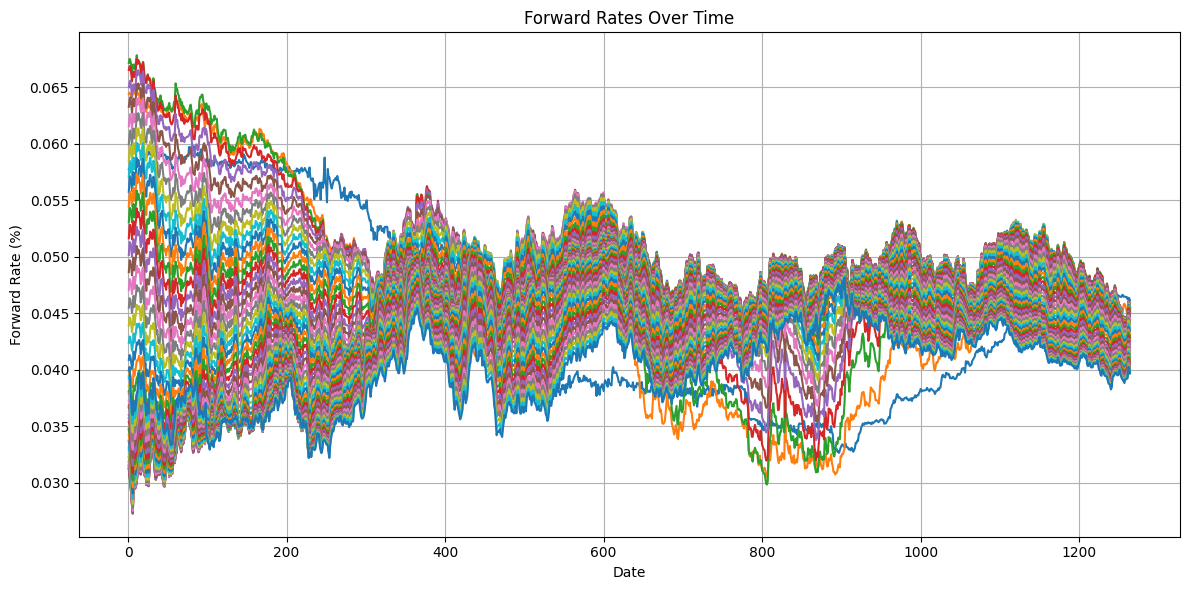

In [4]:
plt.figure(figsize=(12, 6))
for col in fwdrates.columns:
    plt.plot(fwdrates.index, fwdrates[col], label=col)
plt.title("Forward Rates Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

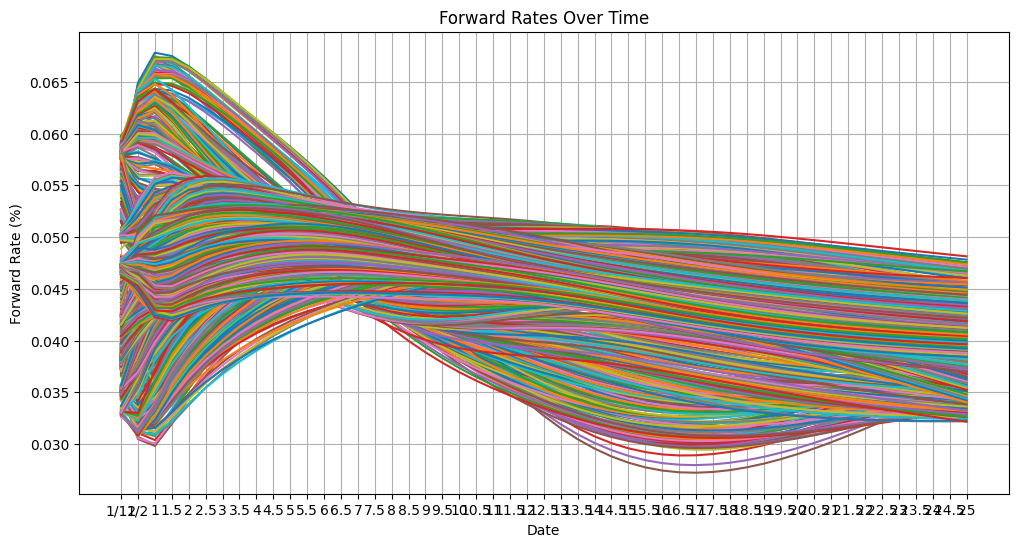

In [5]:
plt.figure(figsize=(12, 6))
fwdrates_transpose= fwdrates.T
for i in fwdrates_transpose.columns:
    plt.plot(fwdrates_transpose.index, fwdrates_transpose[i], label = i)
plt.title("Forward Rates Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.grid(True)
plt.show()

### Principal Component Analysis

In this part, principal component analysis is applied to scaled rate data to identify key factors driving variations. The proportion of variance explained by each factor is computed and accumulated. The number of factors required to capture at least 95% of the total variance is determined. The corresponding magnitudes and directional factors are then extracted. These components help in efficiently modeling rate dynamics.

eigenvalues :  [0.00202884 0.00046289 0.00016368]


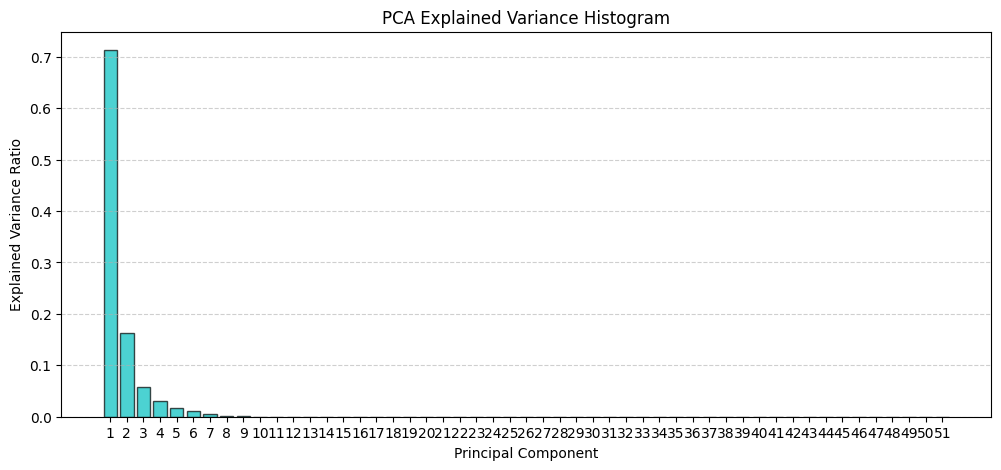

In [6]:
fwdrates_scale = fwdrates.diff()
fwdrates_scale = fwdrates_scale.dropna(axis=0)
pca_features = PCA().fit(fwdrates_scale*np.sqrt(BUSINESS_N_YEAR))
explained_variance = pca_features.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
num_components = np.argmax(cumulative_variance >= EXPLAIN_LEVEL) + 1
eigenvalues = pca_features.explained_variance_
print("eigenvalues : ", eigenvalues[:num_components])
eigenvectors = pca_features.components_
main_components = pd.DataFrame(data = eigenvectors[:num_components].T, columns = ['PCA_'+(str(i)) for i in range(num_components)])
plt.figure(figsize=(12, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='c', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Histogram')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

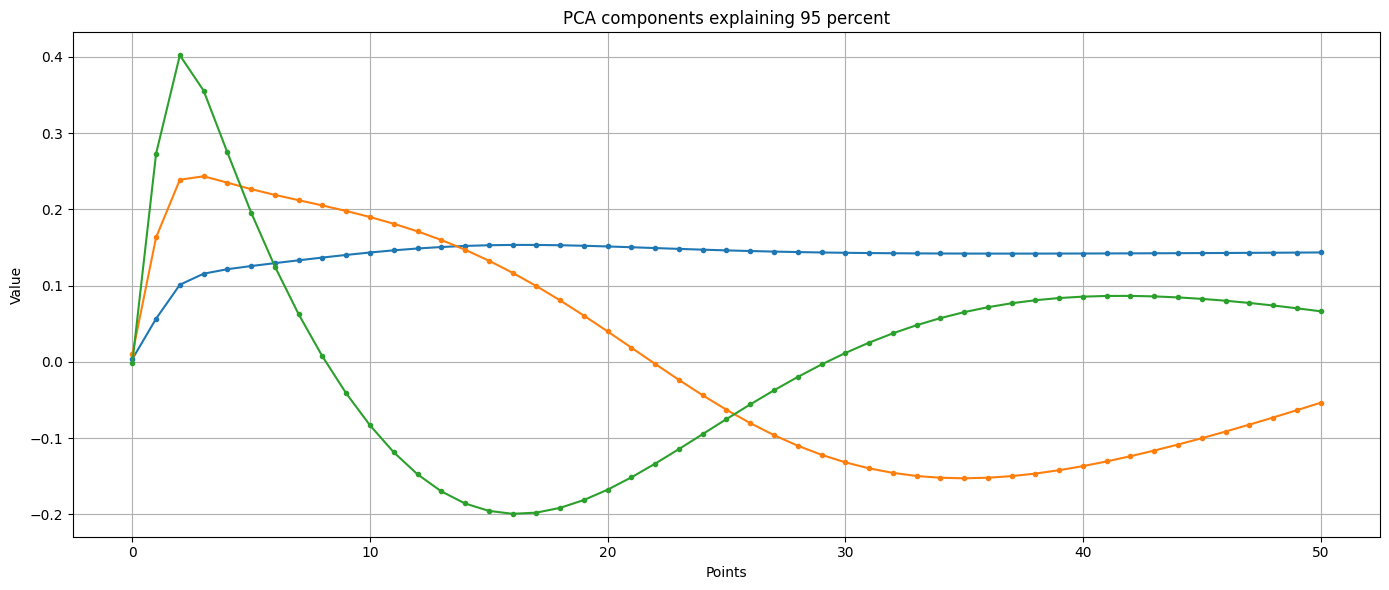

In [7]:
plt.figure(figsize=(14,6))
simulation_tenors = np.linspace(0,50,51)
plt.plot(simulation_tenors, main_components, marker='.')
plt.title('PCA components explaining 95 percent')
plt.xlabel("Points")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

### Volatility structures

We construct smoothed volatility structures from principal components. It derives volatilities by scaling directional factors with their corresponding magnitudes. These volatilities are then interpolated using cubic splines over predefined maturities. The process ensures a smooth representation of how volatilities evolve. The output captures different modes of variation in the data.

In [8]:
volatilitie = []
vol_structure = []
for i in range(num_components):
    volatilitie.append(np.sqrt(eigenvalues[i])*eigenvectors[i])
    vol_structure.append(CubicSpline(tenors, volatilitie[i])) 


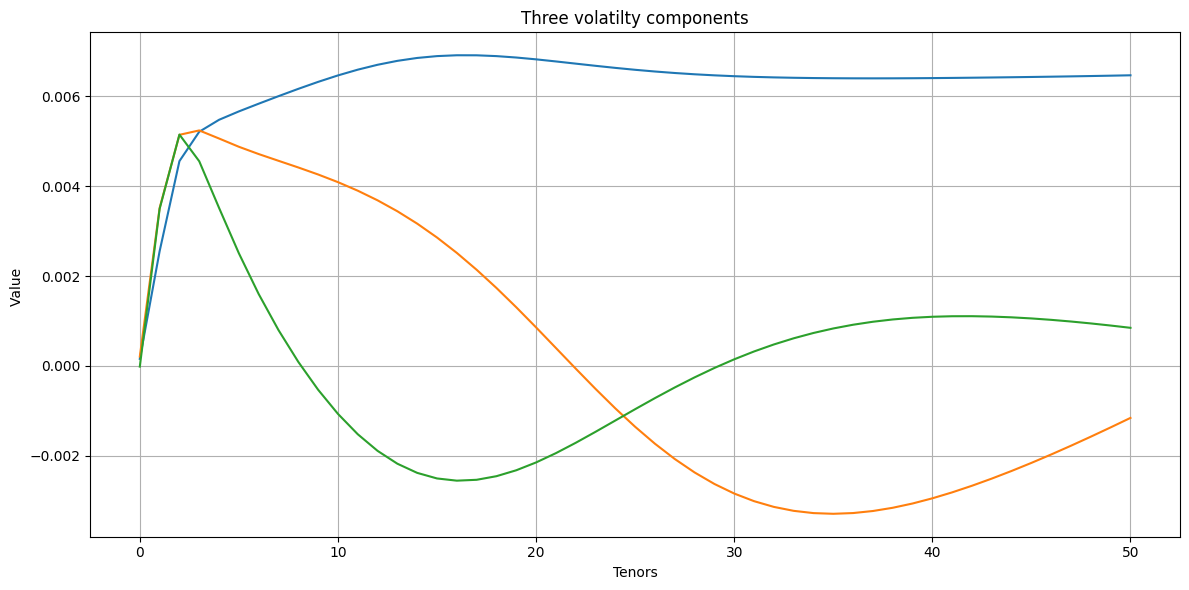

In [9]:
label_structure = ('V1', 'V2','V3')
plt.figure(figsize=(12, 6))
i=0
vols =[]
for item in vol_structure:
    vol = [item(tau) for tau in simulation_tenors]
    vols.append(vol)
    plt.plot(simulation_tenors, vol, label = label_structure[i])
    i = i+1

plt.title("Three volatilty components")
plt.xlabel("Tenors")
plt.ylabel("Value ")
plt.grid(True)
plt.tight_layout()
plt.show()

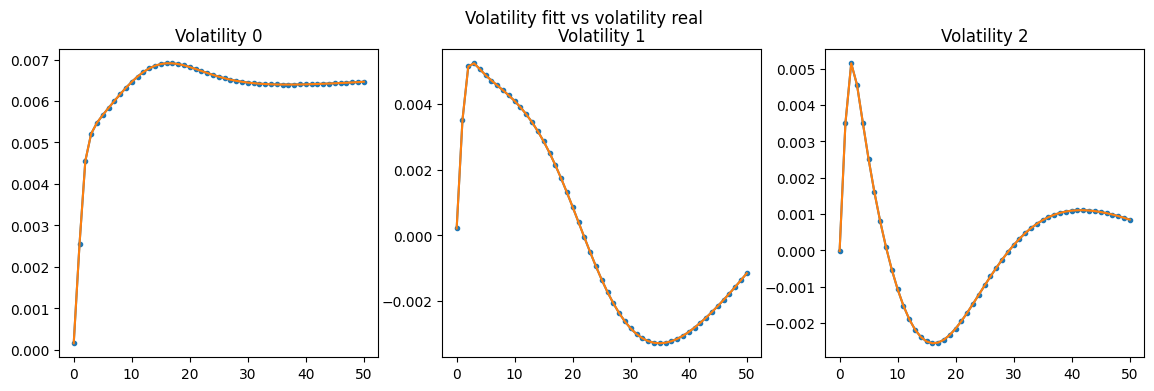

In [10]:
fig, axs = plt.subplots(1, 3,figsize=(14, 4))
fig.suptitle('Volatility fitt vs volatility real')
i = 0
for (vols_real,vol_fit) in zip(volatilitie,vols):
    axs[i].plot(tenors, vols_real, marker='.', label='Discretized volatility')
    axs[i].plot(tenors,vol_fit, label='Fitted volatility')
    axs[i].set_title('Volatility ' +str(i))
    i = i+1
    

https://xilinx.github.io/Vitis_Libraries/quantitative_finance/2021.2/guide_L2/engines/HJM.html

### Computation of drifts 

$$ m(t,T) = \sum_{i=1}^n \sigma_i(t,T) \int_0^T \sigma_i(t,s)ds $$

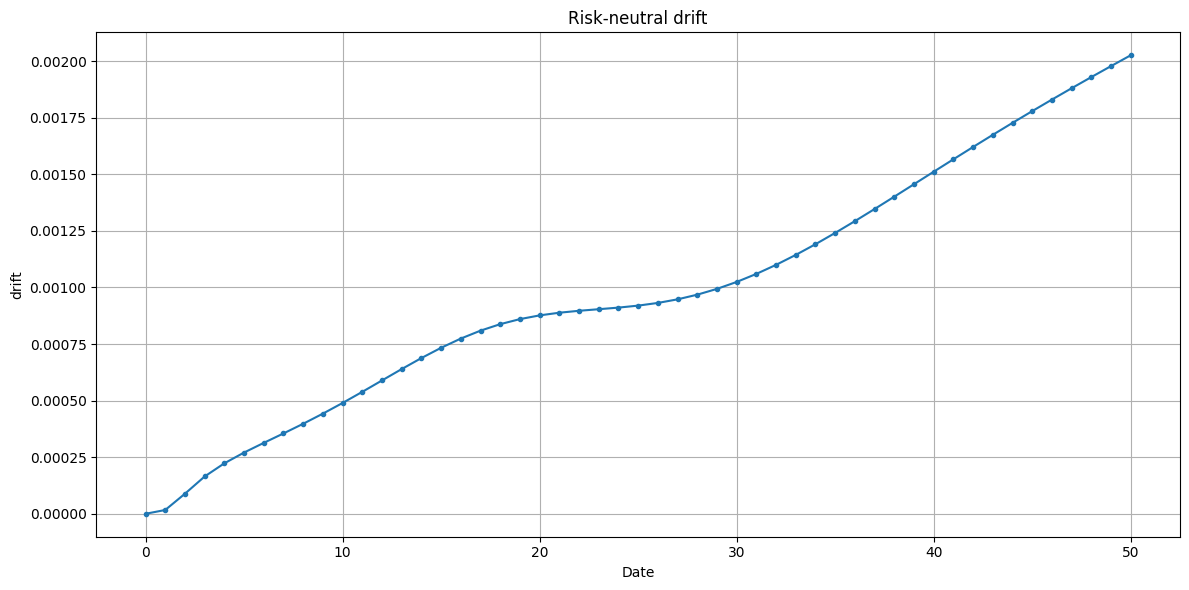

In [11]:
def drift_computation(t,T):
    return sum([vol(T)*vol.integrate(t,T) for vol in vol_structure])

drift = [drift_computation(0,tau) for tau in simulation_tenors]
plt.figure(figsize=(12, 6))
plt.plot(simulation_tenors, drift, marker='.')
plt.title('Risk-neutral drift')
plt.xlabel("Date")
plt.ylabel("drift")
plt.grid(True)
plt.tight_layout()
plt.show()

### SPOT

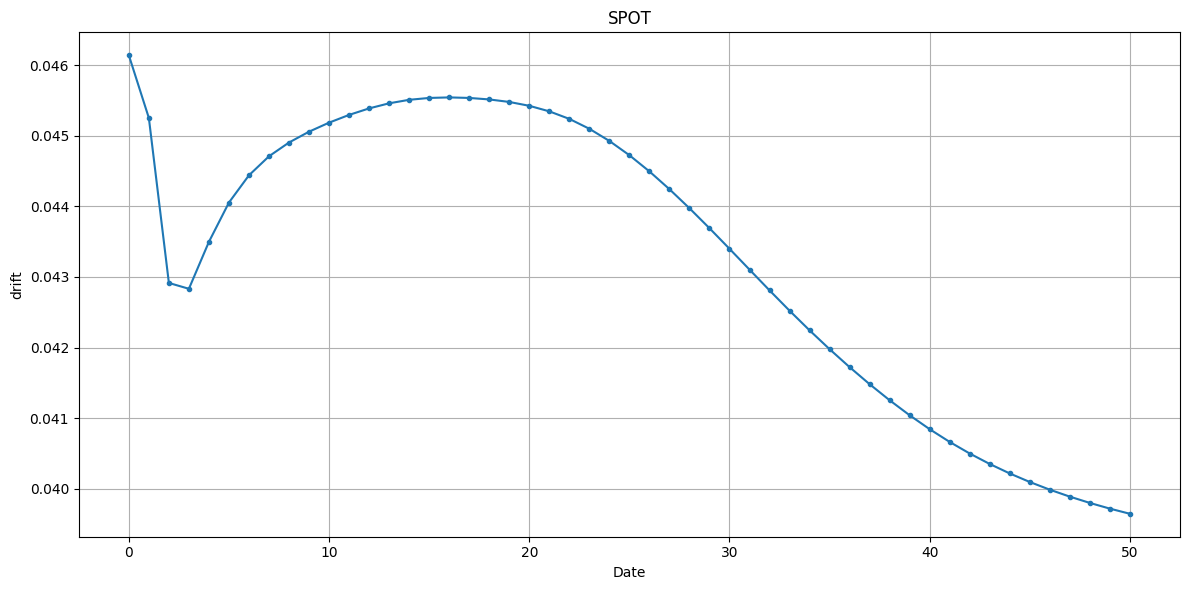

In [12]:
plt.figure(figsize=(12,6))
plt.plot(tenors, spot_rates, marker='.')
plt.title('SPOT')
plt.xlabel("Date")
plt.ylabel("drift")
plt.grid(True)
plt.tight_layout()
plt.show()

### HJM Simulation

In [13]:
np.random.seed(0)

In [14]:
def simulation(forward_rates, tenors, drift_terms, volatility_matrix, timeline):
    #volatility_matrix = np.transpose(volatility_matrix)
    yield timeline[0], np.copy(forward_rates)

    # Iterate over the timeline
    for time_index in range(1, len(timeline)):
        time_step = timeline[time_index] - timeline[time_index - 1]
        previous_forward_rates = forward_rates
        forward_rates = np.copy(forward_rates)
        random_shocks = [np.random.standard_normal() for _ in range(len(volatility_matrix))]

        for tenor_index in range(1, len(tenors)):
            # Compute the new value for forward_rates[tenor_index]
            updated_rate = previous_forward_rates[tenor_index] + drift_terms[tenor_index] * time_step

            # Add the contribution from volatility
            updated_rate += sum( np.sqrt(time_step)*factor_volatility[tenor_index] * random_shocks[factor_index] for factor_index, factor_volatility in enumerate(volatility_matrix)
            )
           
            # Add the effect of the local rate of change
            next_tenor_index = tenor_index + 1 if tenor_index < len(tenors) - 1 else tenor_index - 1
            local_rate_of_change = (previous_forward_rates[next_tenor_index] - previous_forward_rates[tenor_index]) / (
                next_tenor_index - tenor_index
            )
            updated_rate += local_rate_of_change * time_step

            forward_rates[tenor_index] = updated_rate

        # Yield the time and updated forward rates
        yield timeline[time_index],forward_rates


$f(t,T)$ by $t$'

In [15]:
rates = [x for (t,x) in simulation(spot_rates,tenors,drift,vols, timeline)]
columns = [tn for tn in tenors]
df_rates = pd.DataFrame(rates,index=timeline,columns=columns)
df_rates

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0.00000,0.046138,0.045251,0.042916,0.042833,0.043498,0.044054,0.044440,0.044708,0.044903,0.045057,...,0.040665,0.040501,0.040353,0.040219,0.040098,0.039989,0.039891,0.039802,0.039721,0.039648
0.01002,0.046138,0.046162,0.044430,0.044417,0.045019,0.045501,0.045821,0.046034,0.046183,0.046297,...,0.041806,0.041650,0.041509,0.041381,0.041267,0.041164,0.041072,0.040989,0.040914,0.040846
0.02004,0.046138,0.047032,0.045911,0.046127,0.046856,0.047443,0.047859,0.048160,0.048387,0.048567,...,0.042623,0.042496,0.042387,0.042296,0.042219,0.042157,0.042106,0.042067,0.042038,0.042017
0.03006,0.046138,0.047174,0.046216,0.046505,0.047272,0.047888,0.048332,0.048659,0.048911,0.049115,...,0.043278,0.043150,0.043040,0.042947,0.042869,0.042805,0.042754,0.042713,0.042683,0.042661
0.04008,0.046138,0.047829,0.047230,0.047466,0.048090,0.048563,0.048879,0.049094,0.049247,0.049365,...,0.043676,0.043551,0.043443,0.043351,0.043273,0.043209,0.043155,0.043113,0.043079,0.043053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.95992,0.046138,0.037956,0.041391,0.043911,0.046000,0.047799,0.049348,0.050665,0.051753,0.052616,...,0.043592,0.043817,0.044062,0.044323,0.044595,0.044874,0.045158,0.045443,0.045729,0.046015
4.96994,0.046138,0.038795,0.042601,0.045080,0.047050,0.048731,0.050175,0.051398,0.052401,0.053185,...,0.043364,0.043609,0.043875,0.044158,0.044453,0.044755,0.045062,0.045371,0.045682,0.045992
4.97996,0.046138,0.039098,0.043232,0.045939,0.048085,0.049918,0.051501,0.052850,0.053968,0.054858,...,0.045046,0.045291,0.045557,0.045840,0.046135,0.046440,0.046749,0.047061,0.047374,0.047688
4.98998,0.046138,0.038918,0.042877,0.045497,0.047581,0.049361,0.050895,0.052200,0.053279,0.054134,...,0.044802,0.045038,0.045295,0.045568,0.045853,0.046145,0.046441,0.046740,0.047039,0.047338


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


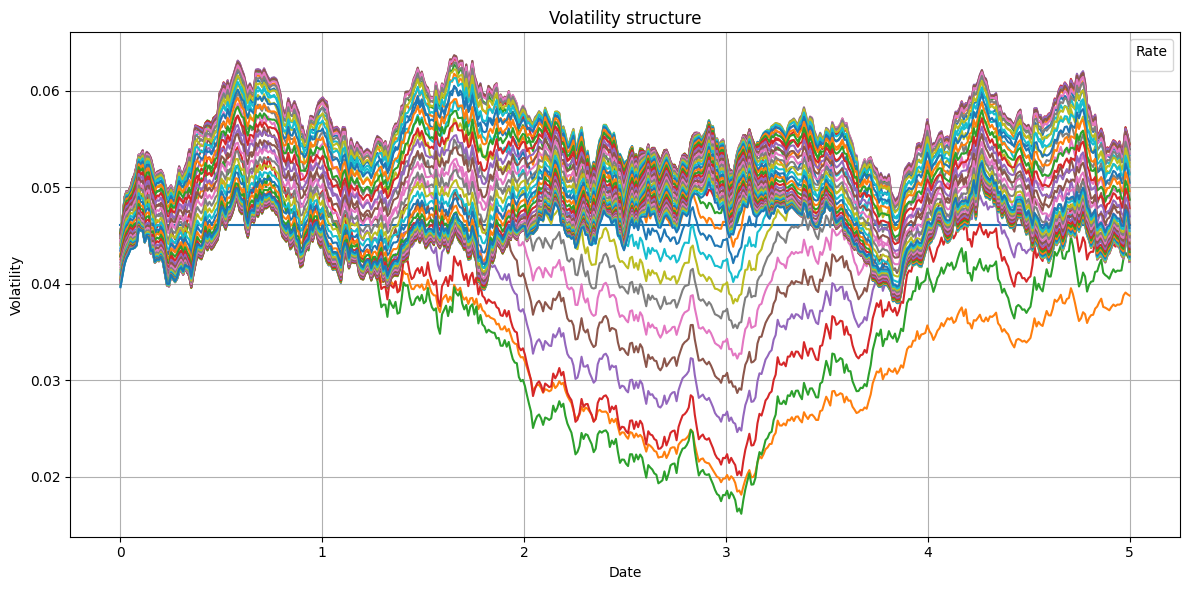

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(timeline,rates)
plt.title("Volatility structure")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend(title="Rate")
plt.tight_layout()
plt.show()

$f(t,T)$ by $T$'

In [17]:
df_rates_T = df_rates.T
df_rates_T.head()

,0.00000,0.01002,0.02004,0.03006,0.04008,0.05010,0.06012,0.07014,0.08016,0.09018,...,4.90982,4.91984,4.92986,4.93988,4.94990,4.95992,4.96994,4.97996,4.98998,5.00000
0,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,...,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138
1,0.045251,0.046162,0.047032,0.047174,0.047829,0.048215,0.048751,0.047637,0.047843,0.047924,...,0.037592,0.037857,0.037691,0.037851,0.037841,0.037956,0.038795,0.039098,0.038918,0.038786
2,0.042916,0.044430,0.045911,0.046216,0.047230,0.047872,0.048690,0.047083,0.047449,0.047766,...,0.041064,0.041502,0.041207,0.041374,0.041344,0.041391,0.042601,0.043232,0.042877,0.042475
3,0.042833,0.044417,0.046127,0.046505,0.047466,0.048137,0.049009,0.047568,0.048035,0.048488,...,0.043689,0.044162,0.043861,0.043959,0.043983,0.043911,0.045080,0.045939,0.045497,0.044976
4,0.043498,0.045019,0.046856,0.047272,0.048090,0.048732,0.049605,0.048453,0.048997,0.049531,...,0.045881,0.046350,0.046073,0.046092,0.046185,0.046000,0.047050,0.048085,0.047581,0.047002


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


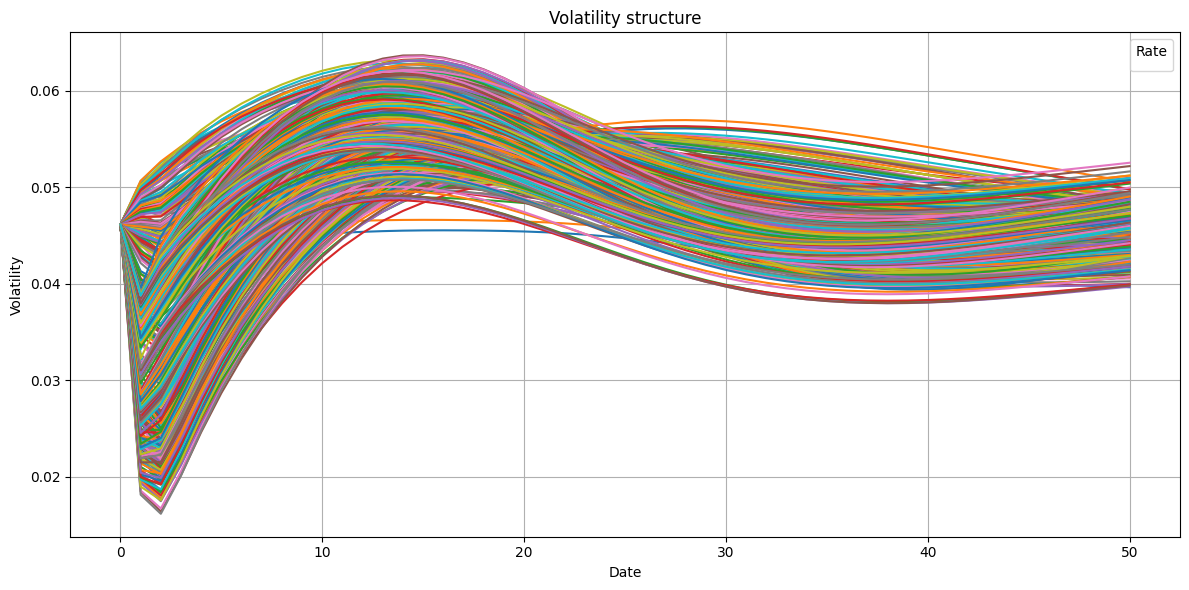

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(df_rates_T.index,df_rates_T )
plt.title("Volatility structure")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend(title="Rate")
plt.tight_layout()
plt.show()

### Extract Rate

In [19]:
ynew = np.interp(0.5, tenors, rates)
ynew

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\33695\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\33695\AppData\Local\Temp\ipykernel_3092\2719251830.py", line 1, in <module>
    ynew = np.interp(0.5, tenors, rates)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<__array_function__ internals>", line 200, in interp
  File "C:\Users\33695\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py", line 1595, in interp
    return interp_func(x, xp, fp, left, right)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: object too deep for desired array

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\33695\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.I